In [17]:
#%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Ellipse
from matplotlib.patheffects import withStroke

import math
import glob

import seaborn as sns
import statistics as stat

from astropy.io import fits
from astropy.table import Table, unique, join, vstack
from astropy.visualization import astropy_mpl_style
from astropy.visualization import simple_norm
from astropy.visualization import make_lupton_rgb

from astropy.visualization import SqrtStretch
from astropy.visualization import ZScaleInterval

from astropy.nddata import Cutout2D
from astropy import units as u
from astropy import constants as Cons
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, Galactic, Angle

#from astroquery.vizier import Vizier
#from astroquery.xmatch import XMatch

plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 3

import csv
import matplotlib.ticker as ticker
from scipy.stats import kde
from math import pi
import pandas as pd
#import match 

from astropy.table import QTable
from astropy.table import hstack

import nilo.loaders as ld

In [18]:
def galactic(ra,dec):
    c = SkyCoord(ra*u.degree, dec*u.degree)
    l = c.galactic.l*u.degree
    b = c.galactic.b*u.degree
    return l, b

def equatorial(l,b):
    c = SkyCoord(l*u.degree, b*u.degree, frame='galactic')
    ra = c.fk5.ra
    dec = c.fk5.dec
    return ra, dec  

In [19]:
####### CATALOGO DE ZANG #####
zang = Table.read('zang_cat.csv', format='csv')
print('Zang+21 completo: ',+len(zang))
print('Galaxias en Zang+21 completo: ',+len(zang[zang['Class_x']=='GALAXY']))

## Hacer el corte entre 0<l<10
zang['l_LONG'], zang['b_LAT'] = galactic(zang['sc_ra'],zang['sc_dec'])

#disc_all = zang[zang['GAL_LONG']>250]#
disc_all = zang[zang['l_LONG']>295]#
disc_all = disc_all[disc_all['l_LONG']<350]
disc_all = disc_all[disc_all['b_LAT']<2]
disc_all = disc_all[disc_all['b_LAT']>-2]

disc = disc_all[disc_all['Class_x']=='GALAXY']
disc_QSO = disc_all[disc_all['Class_x']=='QSO']
disc_S = disc_all[disc_all['Class_x']=='STAR']

ds_all = Table.read('erass1_cl_v0.2_simon.fits', format='fits')
ds = ds_all[ds_all['GAL_LONG']>294]
ds = ds[ds['GAL_LONG']<351]
ds = ds[ds['GAL_LAT']<2.5]
ds = ds[ds['GAL_LAT']>-2.5]

Zang+21 completo:  550124
Galaxias en Zang+21 completo:  191528


In [20]:
## Zhang+21

#(325.7, -2), 1.1, 0.8
dZ2 = disc[disc['l_LONG']>325.7]
dZ2 = dZ2[dZ2['l_LONG']<(325.7+1.1)]
dZ2 = dZ2[dZ2['b_LAT']>-2]
dZ2 = dZ2[dZ2['b_LAT']<(-2+0.8)]

aZ2 = disc_all[disc_all['l_LONG']>325.7]
aZ2 = aZ2[aZ2['l_LONG']<(325.7+1.1)]
aZ2 = aZ2[aZ2['b_LAT']>-2]
aZ2 = aZ2[aZ2['b_LAT']<(-2+0.8)]

dz2_l = min(dZ2['l_LONG']) + ( max(dZ2['l_LONG']) - min(dZ2['l_LONG']) )/2
dz2_b = min(dZ2['b_LAT']) + ( max(dZ2['b_LAT']) - min(dZ2['b_LAT']) )/2
dz2_ra = min(dZ2['sc_ra']) + ( max(dZ2['sc_ra']) - min(dZ2['sc_ra']) )/2
dz2_de = min(dZ2['sc_dec']) + ( max(dZ2['sc_dec']) - min(dZ2['sc_dec']) )/2


#eROSITA
#(325.7, -2), 1.1, 0.8
Z2 = ds[ds['GAL_LONG']>325.7]
Z2 = Z2[Z2['GAL_LONG']<(325.7+1.1)]
Z2 = Z2[Z2['GAL_LAT']>-2]
Z2 = Z2[Z2['GAL_LAT']<(-2+0.8)]

z2_l = min(Z2['GAL_LONG']) + ( max(Z2['GAL_LONG']) - min(Z2['GAL_LONG']) )/2
z2_b = min(Z2['GAL_LAT']) + ( max(Z2['GAL_LAT']) - min(Z2['GAL_LAT']) )/2
z2_ra = min(Z2['RA_CORR']) + ( max(Z2['RA_CORR']) - min(Z2['RA_CORR']) )/2
z2_de = min(Z2['DEC_CORR']) + ( max(Z2['DEC_CORR']) - min(Z2['DEC_CORR']) )/2

#####----------------------------------------------------------
hdu_2 = fits.open('aladin/Z2/news/o_z2_xmm_eb3.fits')[0]
vvv_2 = fits.open('aladin/Z2/news/g_z2_vvv_H.fits')[0]
wcs_2 = WCS(hdu_2.header)

### ------------------------------- Cutouts of Zones -------------------------------


(675, 850)

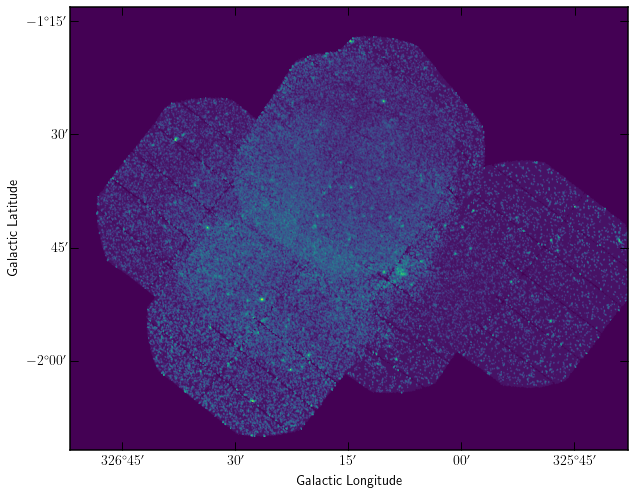

In [21]:
##################  Z2  ##################

#### MANUALMENTE CORTAR CADA objeto 
#(xmm_eb, vvv, sumss, spitzer, decaps, allWise)
hdu_2 = fits.open('aladin/Z2/Z2_XMM-PN-eb4~1.fits')[0]
wcs = WCS(hdu_2.header)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(hdu_2.data, cmap='gray', vmax=1000, interpolation=None, origin='lower')

point_gal = (dz2_l, dz2_b)
position = SkyCoord(point_gal[0]*u.degree, point_gal[1]*u.degree, frame='galactic')
# Make the cutout, including the WCS
cutout = Cutout2D(hdu_2.data, position, (850,850), wcs=wcs)
ax.imshow(cutout.data, origin='lower')  
ax.set_xlabel('Galactic Longitude', size=14)
ax.set_ylabel('Galactic Latitude', size=14)
ax.tick_params(which='major', size=12, labelsize=14)
# Put the cutout image in the FITS HDU
hdu_2.data = cutout.data
# Update the FITS header with the cutout WCS
hdu_2.header.update(cutout.wcs.to_header())
# Write the cutout to a new FITS file
cutout_filename = 'aladin/Z2/news/p_z2_xmm_eb4.fits'
#hdu_2.writeto(cutout_filename, overwrite=True)

hdu_2.shape

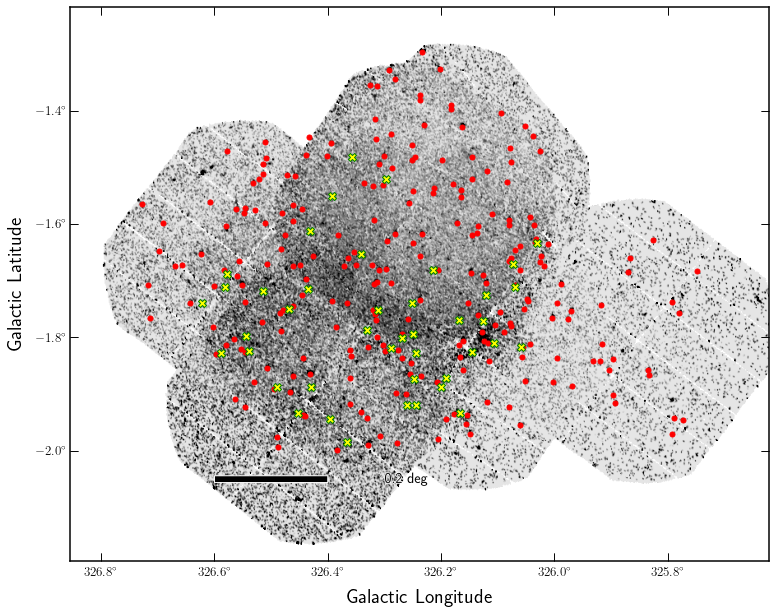

In [22]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection=wcs_2)
norm = simple_norm(hdu_2.data, 'linear', min_percent=0.5, max_percent=99.5)
ax.imshow(hdu_2.data, origin='lower', norm=norm, cmap=plt.cm.gray_r, interpolation=None)

ax.set_xlabel('Galactic Longitude', size=20)
ax.set_ylabel('Galactic Latitude', size=20)

ax.coords[0].set_major_formatter('d.d')
ax.coords[1].set_major_formatter('d.d')


ax.arrow(326.4,-2.05,0.2,0,head_width=0,head_length=0,fc='black',ec='white',width=0.012,transform=ax.get_transform('galactic'))
text = ax.text(326.3, -2.05, '0.2 deg', color='black', fontsize=15, fontweight='bold', transform=ax.get_transform('galactic'),va='center',ha='left')
text.set_path_effects([withStroke(linewidth=1.5, foreground='white')])  # Set edge color to black
    
# Scatter plot
ax.scatter(dZ2['l_LONG'],dZ2['b_LAT'], s=25, c='red', label='Zang+21',transform=ax.get_transform('galactic'))
ax.scatter(Z2['GAL_LONG'],Z2['GAL_LAT'],s=65,marker='X',fc='yellow',ec='green',label='eRosita',transform=ax.get_transform('galactic'))

ax.minorticks_on()
ax.minorticks_on()
ax.tick_params(which='major', axis='x', size=5, labelsize=13, bottom=True, top=True)
ax.tick_params(which='major', axis='y', size=5, labelsize=13, right=True, left=True)
ax.minorticks_on()

ax.set_xticks(ax.get_xticks(minor=True), minor=True)
ax.set_yticks(ax.get_yticks(minor=True), minor=True)
ax.coords[0].set_major_formatter('d.d')
ax.coords[1].set_major_formatter('d.d')
# Legend
#ax.legend()

plt.tight_layout()
#plt.savefig('Z2_withdata.jpg')